In [1]:
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from multiprocessing import Pool

In [2]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

In [3]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True),
    batch_size=1000, shuffle=False,
)


class TransformDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

full_train_dataset = datasets.MNIST('./data', train=True, download=True)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

train_dataset = TransformDataset(train_dataset, transform=transform)
val_dataset = TransformDataset(val_dataset, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)




In [4]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 10),
    nn.Softmax(1)
)
model.compile()

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [6]:
def evaluate(model, val_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
    accuracy = 100. * correct / total
    return accuracy

def train(model, train_loader, val_loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        val_acc = evaluate(model, val_loader)
        print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Accuracy: {val_acc:.2f}%")

train(model, train_loader, val_loader, optimizer, criterion)

Epoch 1 | Train Loss: 1393.1867 | Val Accuracy: 81.40%
Epoch 2 | Train Loss: 1229.8666 | Val Accuracy: 84.06%
Epoch 3 | Train Loss: 1217.9638 | Val Accuracy: 84.58%
Epoch 4 | Train Loss: 1210.5681 | Val Accuracy: 84.93%
Epoch 5 | Train Loss: 1205.5070 | Val Accuracy: 85.64%


In [7]:
batch_acc = []

for data, label in test_loader:
    batch_acc.append((model(data).argmax(dim=1) == label).sum().item()/len(data))
print(torch.mean(torch.tensor(batch_acc)).item() * 100, '%')

85.21000146865845 %


In [8]:
def find_perfect_representation(model, target_label, iterations=100, learning_rate=0.1):
  input_tensor = torch.randn(1, 28, 28, requires_grad=True)

  for i in range(iterations):
    output = model(input_tensor)

    target_activation = output[0, target_label]

    target_activation.backward()
    with torch.no_grad():
      input_tensor += learning_rate * input_tensor.grad
    input_tensor.grad.zero_()

  return input_tensor

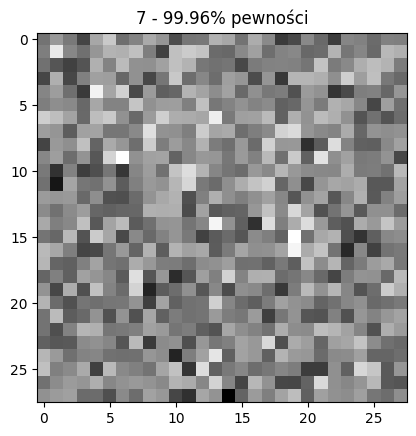

In [9]:
target_label = 7
perfect_representation = find_perfect_representation(model, target_label, 10000)
plt.imshow(perfect_representation.detach().numpy().reshape(28, 28), cmap='gray')
pred = model(perfect_representation.unsqueeze(0))
top_pred = pred.argmax();
plt.title(f"{target_label} - {pred[0, top_pred].item()*100:.2f}% pewności")
plt.show()

In [ ]:

def mean_perfect_representation(target_label):
  print(f"Calculating mean perfect representation for label {target_label}...")
  preds_all_flatten = [p[0].reshape(-1) for p in [find_perfect_representation(model, target_label, 10000) for _ in range(1000)]]
  preds_all_flatten = torch.cat(preds_all_flatten, dim=-1)
  preds_all_mean = torch.mean(preds_all_flatten.reshape(1000, -1), dim=0)
  return preds_all_mean.detach().numpy().reshape(28, 28)


mc_perfect_representations = []
with Pool(10) as p:
  mc_perfect_representations = p.map(mean_perfect_representation, list(range(10)))

In [ ]:
plt.imshow(mc_perfect_representations[7], cmap='gray')
plt.title("Średni idealny obrazek dla 7")

In [ ]:
fix, axs = plt.subplots(2, 5, figsize=(15, 6))
for i, enum in enumerate(zip(axs.flatten(), mc_perfect_representations)):
    ax, data = enum
    ax.imshow(data)
    ax.set_title(f"Label {i}")
    ax.axis('off')
plt.tight_layout()
plt.show()